<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning_workshop/blob/master/LSTM/04_workshop_LSTM_time_series_stacked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics import mean_squared_error

# **Contexto**
---
- Las redes LSTM se pueden apilar de la misma manera que pueden apilar otros tipos de capas. Una adición a la configuración que se requiere es que una capa LSTM antes de cada capa LSTM subsiguiente debe devolver la secuencia.

Esto se hace configurando el parámetro return_sequences en la capa True

# **Data**
---
Este es un problema en el que, dado un año y un mes, la tareas es predecir el número de pasajeros de aerolineas internecionales en unidades de 1.000. Los datos van desde enero de 1949 hasta diciembre de 1960 o 12 años, con 144 observaciones.


In [ ]:
url = 'https://raw.githubusercontent.com/jinfagang/LSTM_learn/master/international-airline-passengers.csv'
data = pd.read_csv(url, usecols=[1], engine = "python")
data_values = data.values.astype('float32')

# **Normalización**
---



In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_values = scaler.fit_transform(data_values)

In [ ]:
data_values[:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

# **Data Split**
---



In [ ]:
train_size = int(len(data_values)*0.67)
test_size = len(data_values) - train_size
train, test = data_values[:train_size, :], data_values[train_size:,:]

# **Create Data**
---



In [ ]:
def create_dataset(data, loock_back = 1):
  dataX, dataY = [], []
  for i in range(len(data)-loock_back-1): 
    item_x = data[i: (i+loock_back), 0]
    item_y = data[i+loock_back,0]
    dataX.append(item_x)
    dataY.append(item_y)
  return np.array(dataX), np.array(dataY)

In [ ]:
loock_back = 3
trainX, trainY = create_dataset(train, loock_back)
testX, testY = create_dataset(test, loock_back)

La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz especifica en forma de [muestras, pasos de tiempo (ventana), caracteristicas]

Los datos preparados tienen la forma: [muestras, carcteristicas]


In [ ]:
print(f'El conjunto de estara dado con {trainX.shape[0]} muestras registros y con {trainX.shape[1]} caracteristicas')
print(f'En esta primera pruebas los pasos de tiempo seran {loock_back}')

El conjunto de estara dado con 92 muestras registros y con 3 caracteristicas
En esta primera pruebas los pasos de tiempo seran 3


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(f'Hacemos un reformateo para cumplir [muestras, pasos de tiempo (ventana), caracteristicas] {trainX.shape}')

Hacemos un reformateo para cumplir [muestras, pasos de tiempo (ventana), caracteristicas] (92, 3, 1)


# **Diseño de LSTM Stacked.**
---


In [ ]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, loock_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, loock_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size = batch_size, verbose = 2, shuffle = True)
    model.reset_states

92/92 - 6s - loss: 0.0620 - 6s/epoch - 66ms/step
92/92 - 0s - loss: 0.0244 - 448ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0229 - 329ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0226 - 339ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0212 - 405ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0201 - 371ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0195 - 470ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0194 - 365ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0190 - 339ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0187 - 372ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0179 - 435ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0169 - 327ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0167 - 375ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0153 - 387ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0136 - 434ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0117 - 358ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0100 - 333ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0091 - 372ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0082 - 450ms/epoch - 5ms/step
92/92 - 0s - loss: 0.0068 - 380ms

# **Predicción**
---



In [ ]:
train_predict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
test_predict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# **Resultados**
---



In [ ]:
train_inverse_predict_X = scaler.inverse_transform(train_predict)
train_inverse_y = scaler.inverse_transform([trainY])

test_inverse_predic_X = scaler.inverse_transform(test_predict)
test_inverse_y = scaler.inverse_transform([testY])

# **Calcular el error**
---



In [ ]:
train_score = math.sqrt(mean_squared_error(train_inverse_y[0], train_inverse_predict_X[:,0]))
print('Puntuación Entrenamiento %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = math.sqrt(mean_squared_error(test_inverse_y[0], test_inverse_predic_X[:,0]))
print('Puntuación Validación %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

Puntuación Entrenamiento 20.59 MSE (4.54 RMSE)
Puntuación Validación 69.45 MSE (8.33 RMSE)


# **Plot**
---



In [ ]:
train_predict_plot = np.empty_like(data_values)
train_predict_plot[:,:] = np.nan
train_predict_plot[loock_back: len(train_inverse_predict_X)+loock_back, :] = train_inverse_predict_X

test_predict_plot = np.empty_like(data_values)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_inverse_predict_X)+(loock_back*2)+1:len(data_values)-1,:] = test_inverse_predic_X

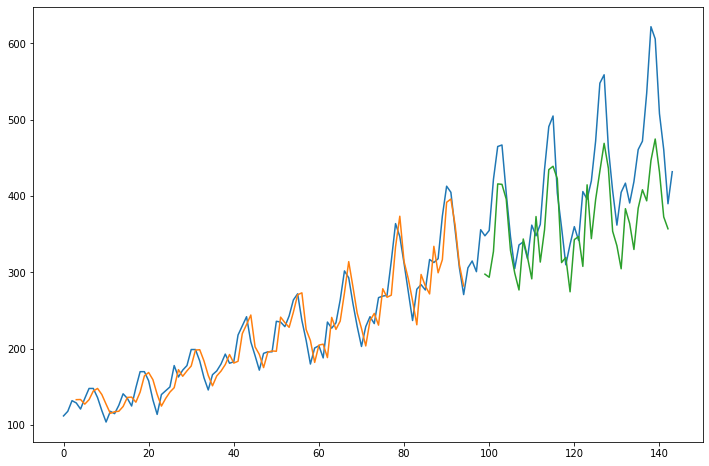

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data_values))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()